# 0- Import library

In [1]:
!pip install torchinfo

In [2]:
# Common
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import shutil
import random

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import cv2
import random
import skimage
from matplotlib import colors
import glob

# File & Data Processing
import pandas as pd
import zipfile
import re
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split

# Model
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
from timm.optim import Lookahead
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
from torchvision import models
from timeit import default_timer as timer

# 1- Introduction to dataset

## 1.1- Download dataset

In [3]:
!gdown https://drive.google.com/uc?id=1VszG1KR4AoDTZl-XxDQFUpXjf7n9VaCq #Train
!gdown https://drive.google.com/uc?id=1bxdaKAC-9QenQz-YCjCUxrLR-mMfVs-f #Label
!gdown https://drive.google.com/uc?id=1Mjsyv8kOFbsrReWwRuIGVZa9AJLI6Fbe #Test
!unzip -q public_train.zip
!unzip -q public_test.zip

Downloading...
From (original): https://drive.google.com/uc?id=1VszG1KR4AoDTZl-XxDQFUpXjf7n9VaCq
From (redirected): https://drive.google.com/uc?id=1VszG1KR4AoDTZl-XxDQFUpXjf7n9VaCq&confirm=t&uuid=86df70b3-dbad-494e-bf20-a360577557e8
To: /kaggle/working/public_train.zip
100%|██████████████████████████████████████| 70.1M/70.1M [00:01<00:00, 39.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bxdaKAC-9QenQz-YCjCUxrLR-mMfVs-f
To: /kaggle/working/public_train_label.csv
100%|██████████████████████████████████████| 5.42k/5.42k [00:00<00:00, 20.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Mjsyv8kOFbsrReWwRuIGVZa9AJLI6Fbe
To: /kaggle/working/public_test.zip
100%|███████████████████████████████████████| 18.1M/18.1M [00:00<00:00, 147MB/s]


## 1.2 - Read images

In [4]:
def show_images(list_image, type_of_dataset):
  plt.figure(figsize=(16,16))
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    image = cv2.imread(list_image[i])
    ax.imshow(image[:, :, ::-1].astype("uint8"))
    ax.set_title(list_image[i])
    ax.axis("off")
  plt.suptitle(f"Read some image from {type_of_dataset} dataset")
  plt.show()

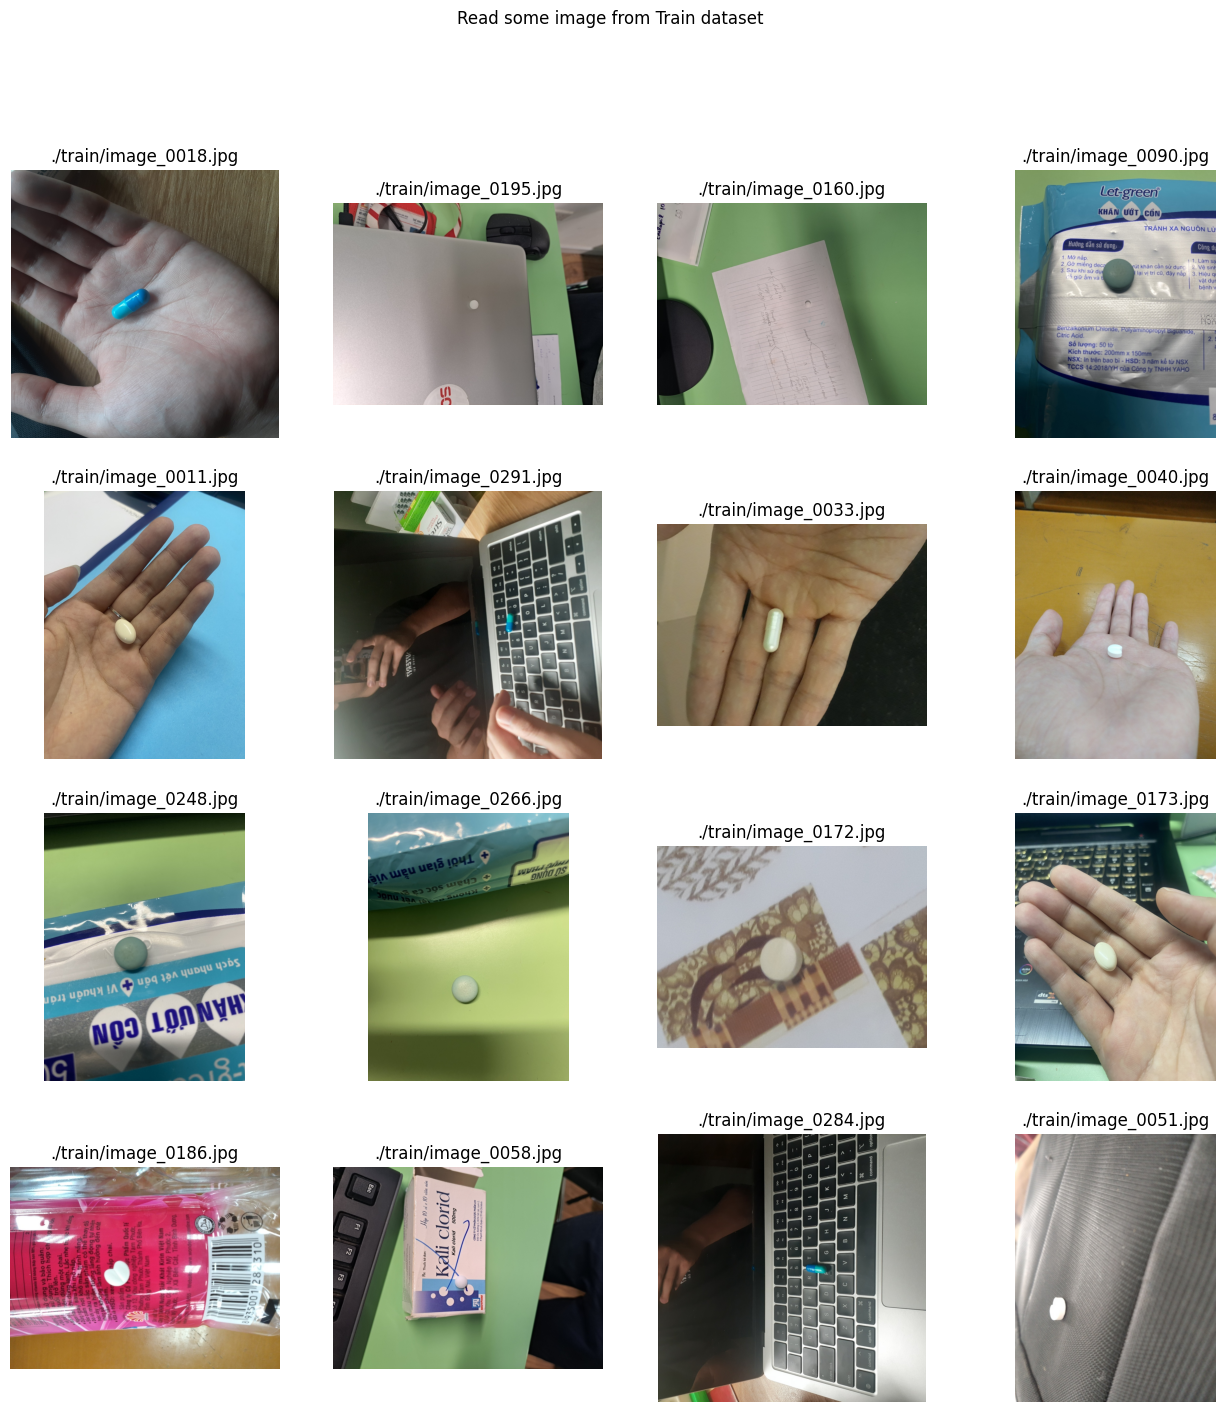

In [5]:
# Get some random image files in train dataset
list_image_files_train = glob.glob("./train/*.jpg")
random_images = random.sample(list_image_files_train, min(16, len(list_image_files_train)))
show_images(random_images, "Train")

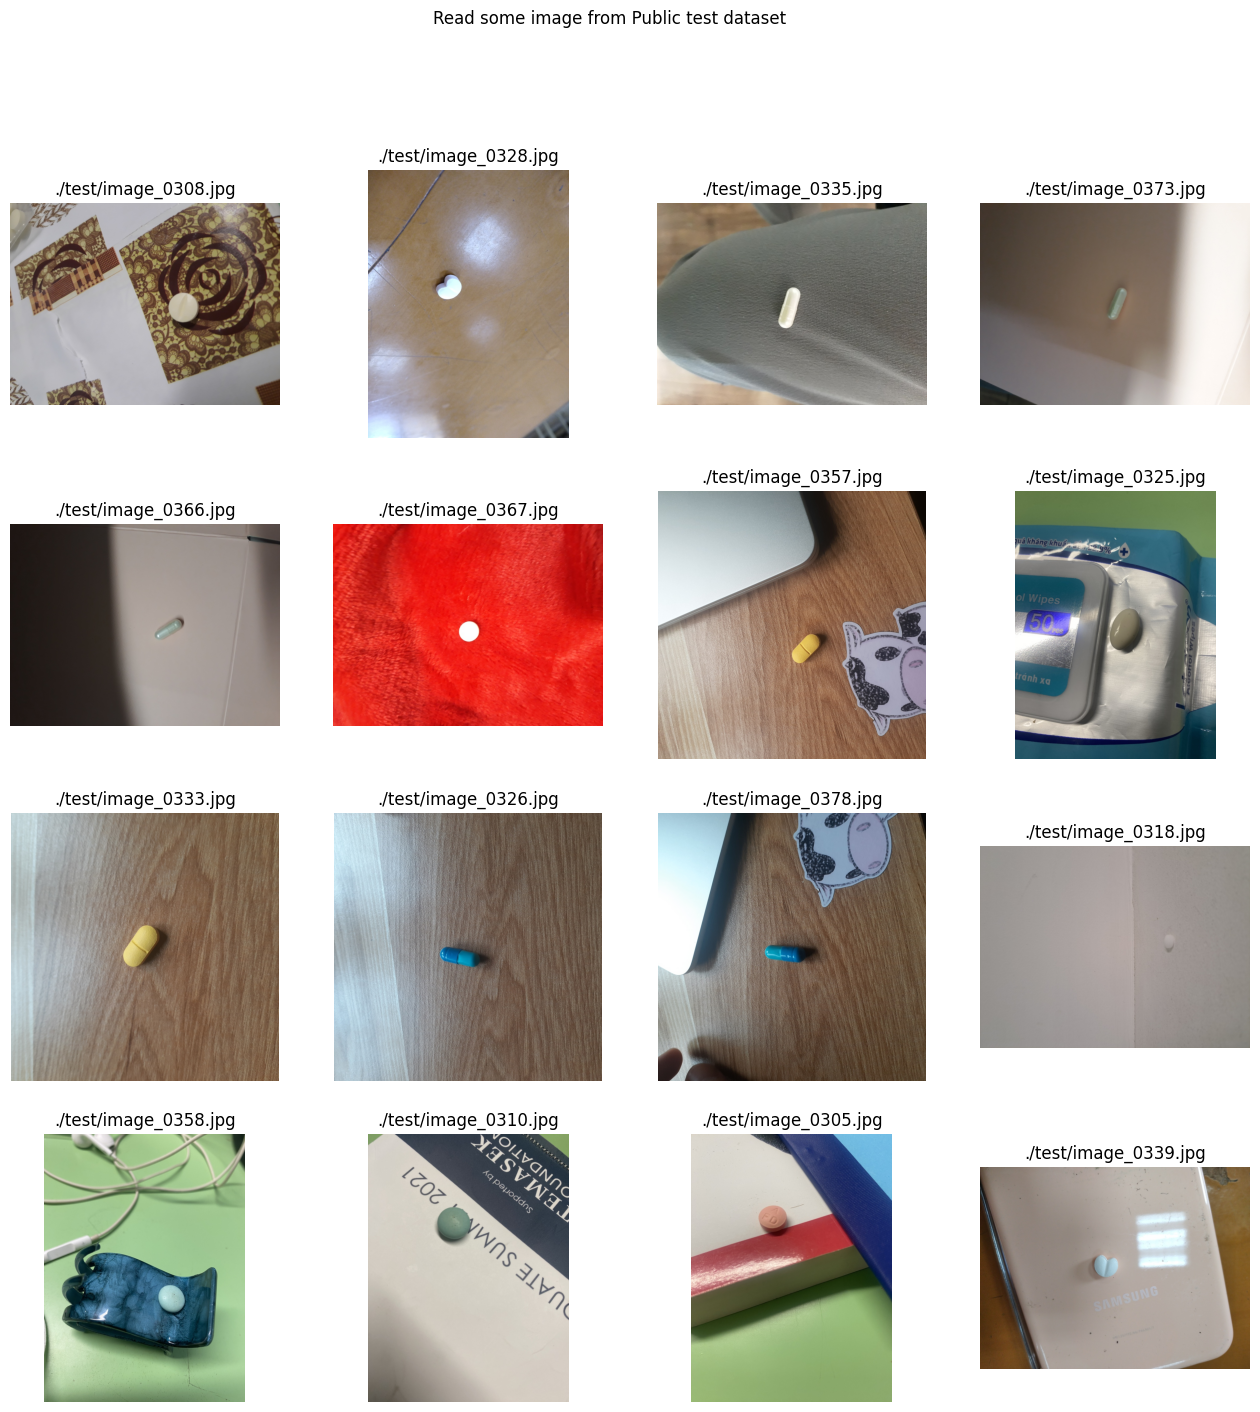

In [6]:
# Get some random image files in Public test dataset
list_image_files_public_test = glob.glob("./test/*.jpg")
random_images = random.sample(list_image_files_public_test, min(16, len(list_image_files_public_test)))
show_images(random_images, "Public test")

# 2- Basic information

## 2.1- Number of class names

In [7]:
list_train_information = pd.read_csv('./public_train_label.csv')
list_train_information

,image_name,label
0,image_0000.jpg,3
1,image_0001.jpg,5
2,image_0002.jpg,8
3,image_0003.jpg,0
4,image_0004.jpg,4
...,...,...
295,image_0295.jpg,1
296,image_0296.jpg,5
297,image_0297.jpg,4
298,image_0298.jpg,4


In [8]:
list_class = list(set(list_train_information['label']))
NUM_CLASSES = len(list_class)
print(f"Class Names in Train dataset: \n{list_class}")
print(f"Total Number of Classes in Train dataset: {NUM_CLASSES}")

Class Names in Train dataset: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total Number of Classes in Train dataset: 10


## 2.2- Total number of images in each class

In [9]:
print(f"Total number of images in Train dataset: {len(list_image_files_train)}")
print(f"Total number of images in Public Test dataset: {len(list_image_files_public_test)}")
# print(f"Total number of images in Private Test dataset: {len(list_image_files_private_test)}")

Total number of images in Train dataset: 300
Total number of images in Public Test dataset: 80


# 3- Preprocess data

In [10]:
def restrict_normalized(channel):
    # Process a single channel: normalize to [0,255]
    channel_std = np.std(channel)
    channel_mean = np.mean(channel)
    channel_norm = (channel - channel_mean) / channel_std
    channel_norm = ((channel_norm - np.min(channel_norm)) /
                    (np.max(channel_norm) - np.min(channel_norm))) * 255
    return channel_norm.astype(np.uint8)

def clahe_equalized(channel):
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(224,224))
    return clahe.apply(channel)

def adjust_gamma(channel, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(channel, table)

def preprocess(image):
    # Expecting 'image' in RGB format with values in [0, 1]

    # Convert RGB (0-1) to LAB (OpenCV expects 8-bit, so scale to [0,255])
    image_uint8 = (image * 255).astype(np.uint8)
    lab = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Process only the L channel for contrast enhancement:
    l = restrict_normalized(l)
    l = clahe_equalized(l)
    l = adjust_gamma(l, 1.2)

    # Merge back and convert to RGB
    lab_processed = cv2.merge((l, a, b))
    image_processed = cv2.cvtColor(lab_processed, cv2.COLOR_LAB2RGB)

    # Scale back to [0,1] if needed
    return image_processed.astype(np.float32) / 255.0

def store_image_process(folder_dir, des_dir):
    processed_path_train = des_dir
    if not os.path.exists(processed_path_train):
        os.mkdir(processed_path_train)
    for fname in os.listdir(folder_dir):
        # Read the full color image
        image = plt.imread(os.path.join(folder_dir, fname))

        # If the image is in uint8, convert to [0,1]
        if image.dtype == np.uint8:
            image = image.astype(np.float32) / 255.0

        # Preprocess the full color image
        processed_img = preprocess(image)

        # Convert back to 8-bit RGB
        processed_img_uint8 = (processed_img * 255).astype(np.uint8)
        pil_img = Image.fromarray(processed_img_uint8, mode='RGB')
        pil_img.save(os.path.join(processed_path_train, fname))

In [11]:
store_image_process('./train', './train_processed')

In [12]:
store_image_process('./test', './public_test_processed')

# 4- Make table of all type of data

In [13]:
train_dataset = list_train_information.copy()
train_dataset['image_name'] = train_dataset['image_name'].apply(lambda x: './train_processed/' + x)
train_dataset.rename(columns={train_dataset.columns[0]: 'image_path'}, inplace=True)
train_dataset

,image_path,label
0,./train_processed/image_0000.jpg,3
1,./train_processed/image_0001.jpg,5
2,./train_processed/image_0002.jpg,8
3,./train_processed/image_0003.jpg,0
4,./train_processed/image_0004.jpg,4
...,...,...
295,./train_processed/image_0295.jpg,1
296,./train_processed/image_0296.jpg,5
297,./train_processed/image_0297.jpg,4
298,./train_processed/image_0298.jpg,4


In [14]:
list_public_test_information = {"image_path": []}
for image in os.listdir('./public_test_processed'):
  list_public_test_information["image_path"].append(os.path.join('./public_test_processed', image))

public_test_dataset = pd.DataFrame(list_public_test_information, index = range(len(list_public_test_information['image_path'])))
public_test_dataset

,image_path
0,./public_test_processed/image_0361.jpg
1,./public_test_processed/image_0374.jpg
2,./public_test_processed/image_0349.jpg
3,./public_test_processed/image_0368.jpg
4,./public_test_processed/image_0316.jpg
...,...
75,./public_test_processed/image_0305.jpg
76,./public_test_processed/image_0331.jpg
77,./public_test_processed/image_0335.jpg
78,./public_test_processed/image_0301.jpg


In [15]:
# list_private_test_information = {"image_path": []}
# for image in os.listdir('./private_test'):
#   list_private_test_information["image_path"].append(os.path.join('./private_test', image))

# private_test_dataset = pd.DataFrame(list_private_test_information, index = range(len(list_private_test_information['image_path'])))
# private_test_dataset

# 5- Visualization

## 5.1- Class distribution in Train dataset

In [16]:
fig = px.pie(names = list(list_train_information['label'].value_counts().index), values = list(list_train_information['label'].value_counts().values), width=800)
fig.update_layout({"title":{'text':f"Class Distribution of Train dataset","x":0.5}})
fig.show()

## 5.2- File size distribution in each type of dataset

In [17]:
train_dataset["file_size"] = train_dataset["image_path"].apply(lambda image: os.path.getsize(image) / 1_000_000)

fig = px.histogram(x = train_dataset["file_size"], nbins = 50, title = f"Distribution of file sizes in Train dataset")

fig.update_layout(
    xaxis_title = "File Size (MB)",
    yaxis_title = "Number of Images",
    showlegend = False,
    bargap = 0.1,
    bargroupgap = 0.1
)

fig.show()

In [18]:
public_test_dataset["file_size"] = public_test_dataset["image_path"].apply(lambda image: os.path.getsize(image) / 1_000_000)

fig = px.histogram(x = public_test_dataset["file_size"], nbins = 50, title = f"Distribution of file sizes in Public test dataset")

fig.update_layout(
    xaxis_title = "File Size (MB)",
    yaxis_title = "Number of Images",
    showlegend = False,
    bargap = 0.1,
    bargroupgap = 0.1
)

fig.show()

In [19]:
# private_test_dataset["file_size"] = private_test_dataset["image_path"].apply(lambda image: os.path.getsize(image) / 1_000_000)

# fig = px.histogram(x = private_test_dataset["file_size"], nbins = 50, title = f"Distribution of file sizes in Private test dataset")

# fig.update_layout(
#     xaxis_title = "File Size (MB)",
#     yaxis_title = "Number of Images",
#     showlegend = False,
#     bargap = 0.1,
#     bargroupgap = 0.1
# )

# fig.show()

# 6- Models

## 6.0- Setup hyperparams

In [20]:
SUBMISSION_MODE = 0 # 0: Not submit, 1: Public dataset, 2: Private dataset
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

PATIENCE = 10
USE_SCHEDULER = False
NUM_EPOCHS = 100
LR = 0.0001
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9

In [21]:
random.seed(0)
np.random.seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6.1- Split data

In [22]:
# Transformation pipeline
transform = {
    'train': transforms.Compose([
        #Rotate the image by given angle.
        transforms.RandomRotation(5),
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((224,224)),
        #Horizontally flip the given PIL Image randomly with a given probability.
        transforms.RandomHorizontalFlip(p = 0.2),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #Rotate the image by given angle.
        transforms.RandomRotation(5),
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((224,224)),
        #Horizontally flip the given PIL Image randomly with a given probability.
        transforms.RandomHorizontalFlip(p = 0.2),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((224,224)),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

In [23]:
class LabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        # Read Dataframe contain information in Train dataset
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]  # Image file name
        label = self.data.iloc[idx, 1]  # Image label

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

# Class for unlabeled test data
class UnlabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image name from the CSV file
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, img_path

In [24]:
# Load full dataset
train_dataset, val_dataset = train_test_split(
    train_dataset,
    test_size = 0.1,
    random_state = 42,
    stratify = train_dataset['label']  # Ensures the label distribution is preserved
)

if (SUBMISSION_MODE == 0):
  train_dataset, test_dataset = train_test_split(
      train_dataset,
      test_size = 0.1,
      random_state = 42,
      stratify = train_dataset['label']  # Ensures the label distribution is preserved
  )
if (SUBMISSION_MODE == 1):
  test_dataset = public_test_dataset
# if (SUBMISSION_MODE == 2):
#   test_dataset = private_test_dataset

print(f"Found {len(train_dataset)} train image filenames belonging to {len(set(train_dataset['label']))} classes.")
print(f"Found {len(val_dataset)} validation image filenames belonging to {len(set(val_dataset['label']))} classes.")
print(f"Found {len(test_dataset)} test image filenames belonging to {len(set(test_dataset['label']))} classes.")

Found 243 train image filenames belonging to 10 classes.
Found 30 validation image filenames belonging to 10 classes.
Found 27 test image filenames belonging to 10 classes.


In [25]:
train_data = LabeledDataset(train_dataset, transform['train'])
val_data = LabeledDataset(val_dataset, transform['val'])
if (SUBMISSION_MODE == 0):
    test_data = LabeledDataset(val_dataset, transform['test'])
else:
    test_data = UnlabeledDataset(test_dataset, transform['test'])

In [26]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

## 6.2- Helper function

In [27]:
def calculate_class_weights(dataset):
  if isinstance(dataset, LabeledDataset):
      labels = dataset.data['label'].tolist()
  else:
      labels = [dataset.dataset.data.iloc[idx, 2] for idx in dataset.indices]

  class_counts = Counter(labels)
  total_samples = sum(class_counts.values())
  class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

  weight_sum = sum(class_weights.values())
  class_weights = {cls: weight / weight_sum for cls, weight in class_weights.items()}

  weights = [class_weights[idx] for idx in range(NUM_CLASSES)]

  weights[0] *= 3
  weights[6] *= 3

  return torch.tensor(weights, dtype=torch.float32)

In [28]:
def save_checkpoint(model, optimizer, epoch, loss, save_path, save_path_best, is_best=False):
    torch.save(model.state_dict(), save_path)
    if is_best:
        torch.save(model.state_dict(), save_path_best)

## 6.3- Training and testing functions

In [29]:
def train(model, num_epoches, train_loader, val_loader, save_path):
    model_results = {
        "train_loss": [], "train_acc": [], "train_f1": [],
        "val_loss": [], "val_acc": [], "val_f1": []
    }
    best_val_f1 = 0.0  # Track the best validation f1 so far.
    start_timer = timer()

    for epoch in range(num_epoches):
        print(f"\nEpoch {epoch+1}/{num_epoches}")

        # ------------- Training Phase -------------
        model.train()
        train_loss, train_acc = 0, 0
        y_true_train, y_pred_train = [], []

        for X, y in tqdm(train_loader, desc="Training", leave=False):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            # Compute predicted classes
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)
            train_loss += loss.item()

            # Collect labels for macro F1 computation
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(y_pred_class.cpu().numpy())

        if USE_SCHEDULER:
            scheduler.step()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_f1 = f1_score(y_true_train, y_pred_train, average='macro')
        model_results["train_loss"].append(train_loss)
        model_results["train_acc"].append(train_acc)
        model_results["train_f1"].append(train_f1)

        # ------------- Validation Phase -------------
        model.eval()
        val_loss, val_acc = 0, 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for X, y in tqdm(val_loader, desc="Validation", leave=False):
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = criterion(y_pred, y)
                val_loss += loss.item()

                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                val_acc += (y_pred_class == y).sum().item() / len(y_pred)

                y_true_val.extend(y.cpu().numpy())
                y_pred_val.extend(y_pred_class.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_f1 = f1_score(y_true_val, y_pred_val, average='macro')
        model_results["val_loss"].append(val_loss)
        model_results["val_acc"].append(val_acc)
        model_results["val_f1"].append(val_f1)

        # Save model only if validation accuracy improves
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            save_info = "Model saved!"
        else:
            save_info = "No improvement."

        # Print the epoch metrics
        print(
            f"Epoch: {epoch+1} | "
            f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Train Macro F1: {train_f1:.4f} | "
            f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}, Val Macro F1: {val_f1:.4f} | {save_info}"
        )

    end_timer = timer()
    print(f"Total training time: {end_timer - start_timer:.3f} seconds")


In [30]:
def predict_labels(model, test_loader, device):
    """Predict labels for unlabeled data."""
    model.eval()
    image_names, all_preds = [], []

    with torch.no_grad():
        for images, img_names in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            image_names.extend(img_names)

    return image_names, all_preds

In [31]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, test_correct, test_preds, test_targets = 0, 0, [], []

    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 2:
                images, labels = batch
                labels = labels.to(device)
            else:
                images = batch[0]
                labels = None

            images = images.to(device)
            outputs = model(images)

            if labels is not None:
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_preds.extend(predicted.cpu().numpy())
                test_targets.extend(labels.cpu().numpy())
            else:
                _, predicted = torch.max(outputs, 1)
                test_preds.extend(predicted.cpu().numpy())

    if labels is not None:
        test_acc = 100 * test_correct / len(test_loader.dataset)
        test_precision = precision_score(test_targets, test_preds, average='macro')
        test_recall = recall_score(test_targets, test_preds, average='macro')
        test_f1 = f1_score(test_targets, test_preds, average='macro')

        class_f1_report = classification_report(test_targets, test_preds)
        avg_f1_score = test_f1
        return test_loss / len(test_loader), test_acc, test_precision, test_recall, test_f1, class_f1_report, avg_f1_score
    else:
        return None, None, None, None, None, None, None

## 6.4- Model

In [32]:
# !!! Do not change anything of this cell !!!
from torch import Tensor
from typing import Type

class BasicBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None,
    ) -> None:
        super(BasicBlock, self).__init__()

        self.expansion = expansion
        self.downsample = downsample
        self.conv1_layer = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )

        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2_layer = nn.Conv2d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=3,
            padding=1,
            bias=False,
        )

        self.batch_norm2 = nn.BatchNorm2d(out_channels * self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1_layer(x)
        out = self.batch_norm1(out)
        out = self.relu(out)

        out = self.conv2_layer(out)
        out = self.batch_norm2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class CNN(nn.Module):
    def __init__(
        self,
        block: Type[BasicBlock],
        img_channels: int = 3,
        num_classes: int = 10,
    ) -> None:
        super(CNN, self).__init__()
        layers = [2, 2, 2, 2]
        self.expansion = 1

        self.in_channels = 64

        self.conv_layer = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.batch_norm = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool_layer = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer_1 = self._make_layer(block, 64, layers[0])
        self.layer_2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer_3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer_4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool_layer = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layer = nn.Linear(512 * self.expansion, num_classes)

    def _make_layer(
        self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, self.expansion, downsample)
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, blocks):
            layers.append(
                block(self.in_channels, out_channels, expansion=self.expansion)
            )
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv_layer(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.maxpool_layer(x)

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)

        x = self.avgpool_layer(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)

        return x

model = CNN(block=BasicBlock, num_classes=NUM_CLASSES).to(device)

In [33]:
# Summary model
model = model.to(device)
summary(model = model,
        input_size=(8, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
CNN (CNN)                                     [8, 3, 224, 224]     [8, 10]              --                   True
├─Conv2d (conv_layer)                         [8, 3, 224, 224]     [8, 64, 112, 112]    9,408                True
├─BatchNorm2d (batch_norm)                    [8, 64, 112, 112]    [8, 64, 112, 112]    128                  True
├─ReLU (relu)                                 [8, 64, 112, 112]    [8, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool_layer)                   [8, 64, 112, 112]    [8, 64, 56, 56]      --                   --
├─Sequential (layer_1)                        [8, 64, 56, 56]      [8, 64, 56, 56]      --                   True
│    └─BasicBlock (0)                         [8, 64, 56, 56]      [8, 64, 56, 56]      --                   True
│    │    └─Conv2d (conv1_layer)              [8, 64, 56, 56]      [8, 64, 56, 56]     

In [34]:
# Config some learning schedule
criterion = nn.CrossEntropyLoss(weight=calculate_class_weights(train_data).to(device))
# criterion = FocalLossWithClassWeights(class_alpha = [0.5, 1.0, 2.0])
optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay=WEIGHT_DECAY)
# optimizer = optim.SGD(model.parameters(), lr = LR, momentum = MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) if USE_SCHEDULER else None

In [35]:
# Training model
train(model, NUM_EPOCHS, train_loader, val_loader, f'./model_best.h5')


Epoch 1/100


Epoch: 1 | Train loss: 2.3652, Train acc: 0.1962, Train Macro F1: 0.1582 | Val loss: 3.0735, Val acc: 0.2083, Val Macro F1: 0.1190 | Model saved!

Epoch 2/100


Epoch: 2 | Train loss: 2.0223, Train acc: 0.2285, Train Macro F1: 0.2096 | Val loss: 2.2932, Val acc: 0.2708, Val Macro F1: 0.2274 | Model saved!

Epoch 3/100


Epoch: 3 | Train loss: 1.6566, Train acc: 0.3172, Train Macro F1: 0.2921 | Val loss: 2.2443, Val acc: 0.2708, Val Macro F1: 0.2063 | No improvement.

Epoch 4/100


Epoch: 4 | Train loss: 1.4026, Train acc: 0.3938, Train Macro F1: 0.3852 | Val loss: 1.9673, Val acc: 0.3750, Val Macro F1: 0.3308 | Model saved!

Epoch 5/100


Epoch: 5 | Train loss: 1.2277, Train acc: 0.4624, Train Macro F1: 0.4558 | Val loss: 2.4761, Val acc: 0.3438, Val Macro F1: 0.3061 | No improvement.

Epoch 6/100


Epoch: 6 | Train loss: 1.0120, Train acc: 0.6089, Train Macro F1: 0.5931 | Val loss: 2.2449, Val acc: 0.3542, Val Macro F1: 0.3200 | No improvement.

Epoch 7/100


Epoch: 7 | Train loss: 0.9423, Train acc: 0.6384, Train Macro F1: 0.6349 | Val loss: 3.3228, Val acc: 0.1979, Val Macro F1: 0.1470 | No improvement.

Epoch 8/100


Epoch: 8 | Train loss: 0.9043, Train acc: 0.6358, Train Macro F1: 0.6462 | Val loss: 2.9180, Val acc: 0.3021, Val Macro F1: 0.2827 | No improvement.

Epoch 9/100


Epoch: 9 | Train loss: 0.7220, Train acc: 0.7056, Train Macro F1: 0.7025 | Val loss: 2.8155, Val acc: 0.4792, Val Macro F1: 0.4540 | Model saved!

Epoch 10/100


Epoch: 10 | Train loss: 0.6149, Train acc: 0.7702, Train Macro F1: 0.7623 | Val loss: 3.3281, Val acc: 0.4792, Val Macro F1: 0.4312 | No improvement.

Epoch 11/100


Epoch: 11 | Train loss: 0.4862, Train acc: 0.8185, Train Macro F1: 0.8137 | Val loss: 3.5972, Val acc: 0.4896, Val Macro F1: 0.4340 | No improvement.

Epoch 12/100


Epoch: 12 | Train loss: 0.5472, Train acc: 0.7823, Train Macro F1: 0.7771 | Val loss: 4.3143, Val acc: 0.3750, Val Macro F1: 0.3922 | No improvement.

Epoch 13/100


Epoch: 13 | Train loss: 0.5612, Train acc: 0.8105, Train Macro F1: 0.8095 | Val loss: 3.6737, Val acc: 0.4792, Val Macro F1: 0.4757 | Model saved!

Epoch 14/100


Epoch: 14 | Train loss: 0.3111, Train acc: 0.8871, Train Macro F1: 0.8863 | Val loss: 3.5932, Val acc: 0.4479, Val Macro F1: 0.4321 | No improvement.

Epoch 15/100


Epoch: 15 | Train loss: 0.2713, Train acc: 0.9032, Train Macro F1: 0.9024 | Val loss: 2.8096, Val acc: 0.5521, Val Macro F1: 0.5187 | Model saved!

Epoch 16/100


Epoch: 16 | Train loss: 0.3006, Train acc: 0.9113, Train Macro F1: 0.9102 | Val loss: 4.2041, Val acc: 0.4062, Val Macro F1: 0.3844 | No improvement.

Epoch 17/100


Epoch: 17 | Train loss: 0.3560, Train acc: 0.8669, Train Macro F1: 0.8639 | Val loss: 3.2902, Val acc: 0.5104, Val Macro F1: 0.4578 | No improvement.

Epoch 18/100


Epoch: 18 | Train loss: 0.3193, Train acc: 0.9113, Train Macro F1: 0.9115 | Val loss: 3.7928, Val acc: 0.5208, Val Macro F1: 0.4724 | No improvement.

Epoch 19/100


Epoch: 19 | Train loss: 0.2138, Train acc: 0.9274, Train Macro F1: 0.9265 | Val loss: 3.2242, Val acc: 0.5104, Val Macro F1: 0.4855 | No improvement.

Epoch 20/100


Epoch: 20 | Train loss: 0.1128, Train acc: 0.9758, Train Macro F1: 0.9757 | Val loss: 3.2348, Val acc: 0.5521, Val Macro F1: 0.5247 | Model saved!

Epoch 21/100


Epoch: 21 | Train loss: 0.0595, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.5424, Val acc: 0.5417, Val Macro F1: 0.5439 | Model saved!

Epoch 22/100


Epoch: 22 | Train loss: 0.0321, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.2404, Val acc: 0.6458, Val Macro F1: 0.5943 | Model saved!

Epoch 23/100


Epoch: 23 | Train loss: 0.0257, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.4017, Val acc: 0.6458, Val Macro F1: 0.6271 | Model saved!

Epoch 24/100


Epoch: 24 | Train loss: 0.0210, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.3208, Val acc: 0.6771, Val Macro F1: 0.6714 | Model saved!

Epoch 25/100


Epoch: 25 | Train loss: 0.0268, Train acc: 0.9919, Train Macro F1: 0.9918 | Val loss: 3.2848, Val acc: 0.5729, Val Macro F1: 0.5633 | No improvement.

Epoch 26/100


Epoch: 26 | Train loss: 0.0242, Train acc: 0.9960, Train Macro F1: 0.9959 | Val loss: 2.9978, Val acc: 0.6458, Val Macro F1: 0.6283 | No improvement.

Epoch 27/100


Epoch: 27 | Train loss: 0.0130, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.0606, Val acc: 0.6042, Val Macro F1: 0.5964 | No improvement.

Epoch 28/100


Epoch: 28 | Train loss: 0.0090, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.2483, Val acc: 0.6146, Val Macro F1: 0.6062 | No improvement.

Epoch 29/100


Epoch: 29 | Train loss: 0.0089, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.3488, Val acc: 0.5729, Val Macro F1: 0.5726 | No improvement.

Epoch 30/100


Epoch: 30 | Train loss: 0.0081, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.4080, Val acc: 0.6458, Val Macro F1: 0.6271 | No improvement.

Epoch 31/100


Epoch: 31 | Train loss: 0.0071, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.4515, Val acc: 0.6458, Val Macro F1: 0.6276 | No improvement.

Epoch 32/100


Epoch: 32 | Train loss: 0.0063, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.4466, Val acc: 0.6458, Val Macro F1: 0.6236 | No improvement.

Epoch 33/100


Epoch: 33 | Train loss: 0.0057, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.4822, Val acc: 0.6146, Val Macro F1: 0.5898 | No improvement.

Epoch 34/100


Epoch: 34 | Train loss: 0.0051, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.4445, Val acc: 0.6146, Val Macro F1: 0.5945 | No improvement.

Epoch 35/100


Epoch: 35 | Train loss: 0.0053, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.4444, Val acc: 0.5729, Val Macro F1: 0.5786 | No improvement.

Epoch 36/100


Epoch: 36 | Train loss: 0.0053, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.5032, Val acc: 0.6771, Val Macro F1: 0.6583 | No improvement.

Epoch 37/100


Epoch: 37 | Train loss: 0.0055, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.6521, Val acc: 0.6458, Val Macro F1: 0.6207 | No improvement.

Epoch 38/100


Epoch: 38 | Train loss: 0.0052, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.6703, Val acc: 0.6042, Val Macro F1: 0.5964 | No improvement.

Epoch 39/100


Epoch: 39 | Train loss: 0.0044, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.7482, Val acc: 0.6146, Val Macro F1: 0.5931 | No improvement.

Epoch 40/100


Epoch: 40 | Train loss: 0.0036, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.8925, Val acc: 0.6146, Val Macro F1: 0.5974 | No improvement.

Epoch 41/100


Epoch: 41 | Train loss: 0.0036, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.7986, Val acc: 0.6146, Val Macro F1: 0.5931 | No improvement.

Epoch 42/100


Epoch: 42 | Train loss: 0.0036, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.7949, Val acc: 0.6458, Val Macro F1: 0.6231 | No improvement.

Epoch 43/100


Epoch: 43 | Train loss: 0.0035, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.7130, Val acc: 0.6458, Val Macro F1: 0.6231 | No improvement.

Epoch 44/100


Epoch: 44 | Train loss: 0.0030, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.7719, Val acc: 0.6458, Val Macro F1: 0.6231 | No improvement.

Epoch 45/100


Epoch: 45 | Train loss: 0.0029, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.8295, Val acc: 0.6458, Val Macro F1: 0.6200 | No improvement.

Epoch 46/100


Epoch: 46 | Train loss: 0.0028, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.7655, Val acc: 0.6458, Val Macro F1: 0.6343 | No improvement.

Epoch 47/100


Epoch: 47 | Train loss: 0.0028, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.7885, Val acc: 0.6458, Val Macro F1: 0.6279 | No improvement.

Epoch 48/100


Epoch: 48 | Train loss: 0.0026, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.9387, Val acc: 0.6458, Val Macro F1: 0.6200 | No improvement.

Epoch 49/100


Epoch: 49 | Train loss: 0.0026, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.8379, Val acc: 0.6458, Val Macro F1: 0.6271 | No improvement.

Epoch 50/100


Epoch: 50 | Train loss: 0.0024, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.9931, Val acc: 0.6458, Val Macro F1: 0.6236 | No improvement.

Epoch 51/100


Epoch: 51 | Train loss: 0.0022, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.8779, Val acc: 0.6458, Val Macro F1: 0.6195 | No improvement.

Epoch 52/100


Epoch: 52 | Train loss: 0.0021, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.9015, Val acc: 0.5729, Val Macro F1: 0.5786 | No improvement.

Epoch 53/100


Epoch: 53 | Train loss: 0.0019, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.0472, Val acc: 0.6042, Val Macro F1: 0.5929 | No improvement.

Epoch 54/100


Epoch: 54 | Train loss: 0.0020, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.0149, Val acc: 0.6146, Val Macro F1: 0.5860 | No improvement.

Epoch 55/100


Epoch: 55 | Train loss: 0.0018, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.9551, Val acc: 0.6458, Val Macro F1: 0.6195 | No improvement.

Epoch 56/100


Epoch: 56 | Train loss: 0.0018, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.8313, Val acc: 0.6458, Val Macro F1: 0.6279 | No improvement.

Epoch 57/100


Epoch: 57 | Train loss: 0.0019, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.0351, Val acc: 0.6458, Val Macro F1: 0.6279 | No improvement.

Epoch 58/100


Epoch: 58 | Train loss: 0.0019, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 3.9845, Val acc: 0.6458, Val Macro F1: 0.6314 | No improvement.

Epoch 59/100


Epoch: 59 | Train loss: 0.0018, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1216, Val acc: 0.5729, Val Macro F1: 0.5595 | No improvement.

Epoch 60/100


Epoch: 60 | Train loss: 0.0018, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.0806, Val acc: 0.6042, Val Macro F1: 0.5964 | No improvement.

Epoch 61/100


Epoch: 61 | Train loss: 0.0016, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.0208, Val acc: 0.6042, Val Macro F1: 0.5964 | No improvement.

Epoch 62/100


Epoch: 62 | Train loss: 0.0015, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1194, Val acc: 0.6042, Val Macro F1: 0.5964 | No improvement.

Epoch 63/100


Epoch: 63 | Train loss: 0.0015, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.0778, Val acc: 0.6146, Val Macro F1: 0.5898 | No improvement.

Epoch 64/100


Epoch: 64 | Train loss: 0.0015, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.0957, Val acc: 0.6042, Val Macro F1: 0.5929 | No improvement.

Epoch 65/100


Epoch: 65 | Train loss: 0.0014, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1424, Val acc: 0.6458, Val Macro F1: 0.6307 | No improvement.

Epoch 66/100


Epoch: 66 | Train loss: 0.0014, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2166, Val acc: 0.6042, Val Macro F1: 0.6040 | No improvement.

Epoch 67/100


Epoch: 67 | Train loss: 0.0013, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1415, Val acc: 0.6458, Val Macro F1: 0.6231 | No improvement.

Epoch 68/100


Epoch: 68 | Train loss: 0.0014, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1423, Val acc: 0.6146, Val Macro F1: 0.5895 | No improvement.

Epoch 69/100


Epoch: 69 | Train loss: 0.0014, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3237, Val acc: 0.6458, Val Macro F1: 0.6229 | No improvement.

Epoch 70/100


Epoch: 70 | Train loss: 0.0013, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1436, Val acc: 0.6458, Val Macro F1: 0.6279 | No improvement.

Epoch 71/100


Epoch: 71 | Train loss: 0.0013, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1903, Val acc: 0.6458, Val Macro F1: 0.6200 | No improvement.

Epoch 72/100


Epoch: 72 | Train loss: 0.0012, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2083, Val acc: 0.6458, Val Macro F1: 0.6307 | No improvement.

Epoch 73/100


Epoch: 73 | Train loss: 0.0012, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2321, Val acc: 0.6146, Val Macro F1: 0.5898 | No improvement.

Epoch 74/100


Epoch: 74 | Train loss: 0.0011, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2763, Val acc: 0.6458, Val Macro F1: 0.6271 | No improvement.

Epoch 75/100


Epoch: 75 | Train loss: 0.0011, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1506, Val acc: 0.6146, Val Macro F1: 0.5969 | No improvement.

Epoch 76/100


Epoch: 76 | Train loss: 0.0012, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2320, Val acc: 0.5729, Val Macro F1: 0.5702 | No improvement.

Epoch 77/100


Epoch: 77 | Train loss: 0.0011, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1133, Val acc: 0.6146, Val Macro F1: 0.5974 | No improvement.

Epoch 78/100


Epoch: 78 | Train loss: 0.0010, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.0205, Val acc: 0.6042, Val Macro F1: 0.6040 | No improvement.

Epoch 79/100


Epoch: 79 | Train loss: 0.0011, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2061, Val acc: 0.6458, Val Macro F1: 0.6279 | No improvement.

Epoch 80/100


Epoch: 80 | Train loss: 0.0010, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2698, Val acc: 0.6458, Val Macro F1: 0.6271 | No improvement.

Epoch 81/100


Epoch: 81 | Train loss: 0.0010, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2705, Val acc: 0.6042, Val Macro F1: 0.5929 | No improvement.

Epoch 82/100


Epoch: 82 | Train loss: 0.0009, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3074, Val acc: 0.6146, Val Macro F1: 0.5862 | No improvement.

Epoch 83/100


Epoch: 83 | Train loss: 0.0009, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3889, Val acc: 0.5729, Val Macro F1: 0.5755 | No improvement.

Epoch 84/100


Epoch: 84 | Train loss: 0.0008, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2526, Val acc: 0.6458, Val Macro F1: 0.6243 | No improvement.

Epoch 85/100


Epoch: 85 | Train loss: 0.0009, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3412, Val acc: 0.6458, Val Macro F1: 0.6300 | No improvement.

Epoch 86/100


Epoch: 86 | Train loss: 0.0009, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.1853, Val acc: 0.6458, Val Macro F1: 0.6243 | No improvement.

Epoch 87/100


Epoch: 87 | Train loss: 0.0009, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2599, Val acc: 0.6146, Val Macro F1: 0.5862 | No improvement.

Epoch 88/100


Epoch: 88 | Train loss: 0.0008, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2496, Val acc: 0.6458, Val Macro F1: 0.6271 | No improvement.

Epoch 89/100


Epoch: 89 | Train loss: 0.0009, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3434, Val acc: 0.6042, Val Macro F1: 0.5976 | No improvement.

Epoch 90/100


Epoch: 90 | Train loss: 0.0008, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2887, Val acc: 0.6458, Val Macro F1: 0.6243 | No improvement.

Epoch 91/100


Epoch: 91 | Train loss: 0.0008, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3710, Val acc: 0.6458, Val Macro F1: 0.6271 | No improvement.

Epoch 92/100


Epoch: 92 | Train loss: 0.0007, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3907, Val acc: 0.6042, Val Macro F1: 0.6012 | No improvement.

Epoch 93/100


Epoch: 93 | Train loss: 0.0007, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.2937, Val acc: 0.6458, Val Macro F1: 0.6271 | No improvement.

Epoch 94/100


Epoch: 94 | Train loss: 0.0007, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3097, Val acc: 0.6146, Val Macro F1: 0.5969 | No improvement.

Epoch 95/100


Epoch: 95 | Train loss: 0.0007, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3424, Val acc: 0.6042, Val Macro F1: 0.6040 | No improvement.

Epoch 96/100


Epoch: 96 | Train loss: 0.0007, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.3348, Val acc: 0.6042, Val Macro F1: 0.5976 | No improvement.

Epoch 97/100


Epoch: 97 | Train loss: 0.0007, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.4116, Val acc: 0.6458, Val Macro F1: 0.6200 | No improvement.

Epoch 98/100


Epoch: 98 | Train loss: 0.0007, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.5186, Val acc: 0.6146, Val Macro F1: 0.6002 | No improvement.

Epoch 99/100


Epoch: 99 | Train loss: 0.0007, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.4626, Val acc: 0.5729, Val Macro F1: 0.5702 | No improvement.

Epoch 100/100


Epoch: 100 | Train loss: 0.0006, Train acc: 1.0000, Train Macro F1: 1.0000 | Val loss: 4.4033, Val acc: 0.6042, Val Macro F1: 0.5976 | No improvement.
Total training time: 241.066 seconds


# 7- Test

In [36]:
if (SUBMISSION_MODE == 0):
  checkpoint = torch.load(f'./model_best.h5', map_location=device)
  model.load_state_dict(checkpoint, strict=False)
  test_loss, test_acc, test_precision, test_recall, test_f1, class_f1_scores, avg_f1_score = evaluate_model(
      model, test_loader, criterion, device
  )
  print(f"Test Loss: {test_loss:.4f}")
  print(f"Test Accuracy: {test_acc:.2f}%")
  print(f"Test Precision: {test_precision:.4f}")
  print(f"Test Recall: {test_recall:.4f}")
  print(f"Test F1 Score: {test_f1:.4f}")
  print(f"Class-wise F1 Scores:\n {class_f1_scores}")
  print(f"Average F1-Score: {avg_f1_score:.4f}")

<ipython-input-36-4462772249f5>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Loss: 3.3458
Test Accuracy: 66.67%
Test Precision: 0.7400
Test Recall: 0.6667
Test F1 Score: 0.6743
Class-wise F1 Scores:
               precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.67      0.80         3
           2       1.00      0.33      0.50         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       0.67      0.67      0.67         3
           7       0.40      0.67      0.50         3
           8       0.25      0.33      0.29         3
           9       0.75      1.00      0.86         3

    accuracy                           0.67        30
   macro avg       0.74      0.67      0.67        30
weighted avg       0.74      0.67      0.67        30

Average F1-Score: 0.6743


# 8- Submission